In [1]:
from glob import glob
import uproot as ur
import numpy as np
import json, os
import os.path as osp
from tqdm.auto import tqdm
from json import load
from phc import module_reload, plot_hist
module_reload('zhh')
from zhh import parse_sample_path, get_preselection_passes, ProcessIndex, get_chunks_factual, EventCategories, sample_weight, presel_stack
version = 'v1'

REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH'
DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionFinal/{version}'
INDEX_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreateRawIndex/v1'

processes = np.load(f'{INDEX_DIR}/processes.npy')
samples = np.load(f'{INDEX_DIR}/samples.npy')
chunks = np.load(f'{DATA_ROOT}/../../CreatePreselectionChunks/v1/chunks.npy')

Validate chunks

In [5]:
for chunk in chunks:
    with open(f'{DATA_ROOT}/{chunk["branch"]}_FinalStateMeta.json') as metaf:
        meta = load(metaf)
        
        if meta['nEvtSum'] != chunk['chunk_size']:
            raise Exception(f"Chunk mismatch for branch <{chunk['branch']}> : {meta['nEvtSum']} vs {chunk['chunk_size']}")

Exception: Chunk mismatch for branch <0> : 3583 vs 3600

In [5]:
files = ['_PreSelection_llHH.root',
         '_PreSelection_vvHH.root',
         '_PreSelection_qqHH.root',
         '_FinalStates.root',
         '_FinalStateMeta.json',
         '.slcio',
         '_Source.txt']

sel_chunks = chunks[chunks['chunk_start'] == 0]
to_delete = []
for chunk in sel_chunks:
    for f in files:
        path = f'{DATA_ROOT}/{chunk["branch"]}{f}'
        if osp.isfile(path):
            to_delete.append(path)

for p in tqdm(to_delete):
    os.remove(p)

In [5]:
chunks[chunks['branch'] == 12902]

array([(12902, 'eeveev', 'eeveev_RR', '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/6f_eeWW/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I108622.Peeveev.eR.pR.n001.d_dstm_10322_0.slcio', 0, 0, 1)],
      dtype=[('branch', '<i4'), ('process', '<U60'), ('proc_pol', '<U64'), ('location', '<U512'), ('n_chunks', '<i4'), ('chunk_start', '<i4'), ('chunk_size', '<i4')])

Introduce indices on samples and processes (included in future runs)

In [12]:
dtype_sample = ProcessIndex.dtype_sample
dtype_process = ProcessIndex.dtype_process

if not 'sid' in samples.dtype.names:
    samples_new = np.empty(len(samples), dtype=dtype_sample)
    samples_new['sid'] = np.arange(len(samples))
    for col in samples.dtype.names:
        samples_new[col] = samples[col]
        
    if len(samples) == len(samples_new):
        np.save(f'{INDEX_DIR}/samples.npy', samples_new)

if not 'pid' in processes.dtype.names:
    #processes_new = np.array([pids, *(processes[col] for col in processes.dtype.names)], dtype=dtype_process)
    processes_new = np.empty(len(processes), dtype=dtype_process)
    processes_new['pid'] = np.arange(len(processes))
    for col in processes.dtype.names:
        processes_new[col] = processes[col]

    if len(processes) == len(processes_new):
        np.save(f'{INDEX_DIR}/processes.npy', processes_new)
        
print('Conversion successful')

Conversion successful


Prototyping

In [16]:
results = get_preselection_passes(DATA_ROOT)

  0%|          | 0/15497 [00:00<?, ?it/s]

In [17]:
np.save(f'{REPO_ROOT}/preselection.npy', results)

In [10]:
results = np.load(f'{REPO_ROOT}/preselection.npy')

In [15]:
from ast import literal_eval as make_tuple
import json

def test_meta_files(DATA_ROOT:str=DATA_ROOT)->bool:
    files = glob(f'{DATA_ROOT}/*_Source.txt')
    #branches = list(map(lambda x: x.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0], files))

    for f in tqdm(files):
        branch = f.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0]
        
        if osp.isfile(f'{DATA_ROOT}/{branch}_FinalStateMeta.json'):
            with open(f, 'r') as file:
                src_spec = file.read()
                if src_spec.startswith('('):
                    src_file, chunk_start, chunk_end = make_tuple(src_spec)
                else:
                    src_file = src_spec
            
            # Read metadata
            with open(f'{DATA_ROOT}/{branch}_FinalStateMeta.json', 'r') as file:
                meta = json.load(file)

            n_gen = meta['nEvtSum']
            proc = meta["processName"]
            
            if proc == '' or n_gen == 0:
                print(src_file)
                raise Exception(branch)
    
    return True

In [16]:
test_meta_files()

  0%|          | 0/14449 [00:00<?, ?it/s]

True

In [ ]:
for entry in results:
    print(f'{entry["proc_pol"]} | {entry["n_gen"]} events | wt: {entry["weight"]} | {entry["n_pass_llhh"]} : {entry["n_pass_vvhh"]} : {entry["n_pass_qqhh"]}')
    
#np.save(f'{REPO_ROOT}/results.npy', results)

Preselection Detailed

In [11]:
a = ur.open(f'{DATA_ROOT}/{branch}_PreSelection_{presel}.root:eventTree')

In [10]:
if True:
    DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionFinal/{version}'
    branch = 0
    presel = 'llHH'
else:
    DATA_ROOT = f'/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/output'
    branch = 'zhh'
    presel = 'llHH'

In [3]:
a = ur.open(f'{DATA_ROOT}/{branch}_FinalStates.root')
b = a['eventTree']

In [3]:
chunks_factual = get_chunks_factual(DATA_ROOT, chunks)

In [16]:
module_reload('zhh')
from zhh import presel_stack

presel_results = presel_stack(DATA_ROOT, processes, chunks_factual, [0,1])#chunks['branch'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
chunks_factual

array([(    0, '2f_z_bhabhag', '2f_z_bhabhag_LL', '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/2f_Z_bhabhag/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I250101.P2f_z_bhabhag.eL.pL.n001.d_dstm_10366_8.slcio', 0,    0, 3600, 3583),
       (    1, '2f_z_bhabhag', '2f_z_bhabhag_LL', '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/2f_Z_bhabhag/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I250101.P2f_z_bhabhag.eL.pL.n001.d_dstm_10366_8.slcio', 1, 3600, 3600, 3582),
       (    2, '2f_z_bhabhag', '2f_z_bhabhag_LL', '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/2f_Z_bhabhag/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I250101.P2f_z_bhabhag.eL.pL.n001.d_dstm_10366_8.slcio', 2, 7200, 3600, 3582),
       ...,
       (15494, 'yyyyvv', 'yyyyvv_RL', '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/6f_yyyyZ/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E5

In [21]:
files = glob(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/[0-9]*.npy')
size_tot = chunks_factual['chunk_size_factual'].sum()
presel_results = None
pointer = 0

for file in tqdm(files):
    part = np.load(file)
    if presel_results is None:
        presel_results = np.zeros(size_tot, dtype=part.dtype)
        
    presel_results[pointer:(pointer+len(part))] = part
    pointer += len(part)

  0%|          | 0/16 [00:00<?, ?it/s]

In [23]:
pids = np.unique(presel_results['pid'])
weights = np.zeros(len(pids), dtype=[('pid', 'H'), ('weight', 'f')])
weights['pid'] = pids

for pid in pids:
    process = processes[processes['pid'] == pid][0]
    pol_em, pol_ep = process['pol_e'], process['pol_p']
    cross_sec = process['cross_sec']
    
    n_gen = np.sum(presel_results['pid'] == pid)
    
    weights['weight'][weights['pid'] == pid] = sample_weight(cross_sec, (pol_em, pol_ep), n_gen)

In [25]:
if False:
    presel_results = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_results.npy')
    weights = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_weights.npy')
else:
    np.save(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_results.npy', presel_results)
    np.save(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_weights.npy', weights)

In [28]:
import matplotlib.pyplot as plt
category_map = { key:value for key, value in EventCategories.EVENT_CATEGORY_TRUE.__dict__.items() if not key.startswith('__') and not callable(key)}
category_map_inv = { v: k for k, v in category_map.items() }

In [29]:
unq_processes = np.unique(processes['process'])
expected_events = np.zeros(len(unq_processes), dtype=[('process', '<U60'), ('evt_expeceted', 'f')])
expected_events['process'] = unq_processes

for process_name in unq_processes:
    for process in processes[processes['process'] == process_name]:
        weight = weights['weight'][weights['pid'] == process['pid']][0]
        expected_events['evt_expeceted'][expected_events['process'] == process_name] += np.sum(chunks_factual['chunk_size_factual'][chunks_factual['proc_pol'] == process['proc_pol']])*weight
        
res = 0.
for process_name in ['e1e1hh', 'e2e2hh', 'e3e3hh']:
    res += expected_events['evt_expeceted'][expected_events['process'] == process_name][0]

print(f'expected llHH: {res:.2f} events')

expected llHH: 41.17 events


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

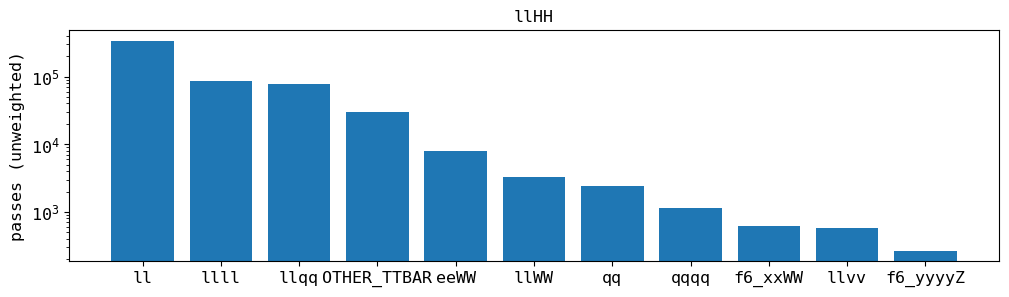

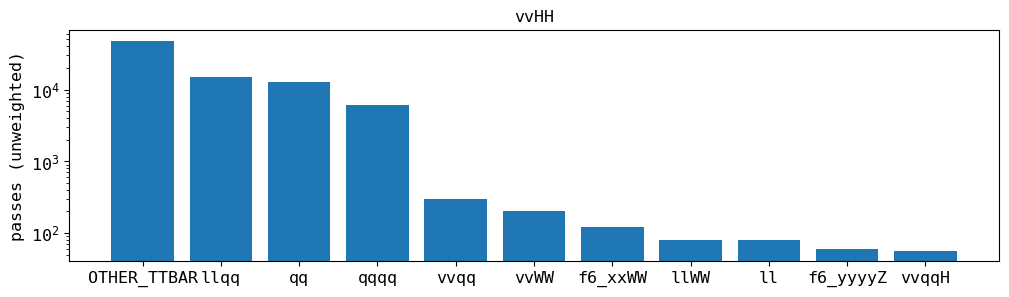

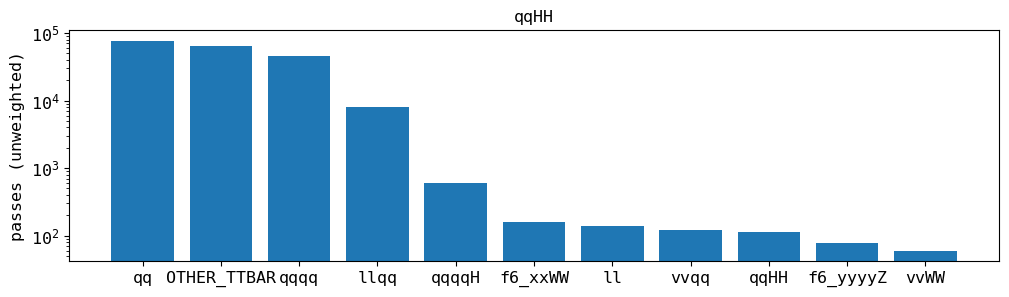

In [30]:
event_categories = np.unique(presel_results['event_category'])
event_categories = event_categories[event_categories != 0]
per_cat = {}

for presel in ['ll', 'vv', 'qq']:
    dtype = [
        ('category', 'i'),
        ('passes', 'f')
    ]
    passes_per_cat = np.zeros(len(event_categories), dtype=dtype)
    passes_per_cat['category'] = event_categories
    
    i = 0
    for category in tqdm(event_categories):
        passes_per_cat[i]['category'] = category
        events = presel_results[presel_results['event_category'] == category]
        
        res = 0.
        for pid in np.unique(events['pid']):
            subset = events[events['pid'] == pid]
            res += np.sum(subset[f'{presel}_pass'] == 1) * weights['weight'][weights['pid'] == pid][0]
        
        passes_per_cat[i]['passes'] = res
        
        i += 1
            
    per_cat[presel] = passes_per_cat
        
    sorted = passes_per_cat[np.argsort(-passes_per_cat['passes'])][:11]
    categories = []
    for s in sorted:
        categories.append(category_map_inv[s['category']])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(categories, sorted['passes'])
    ax.set_title(f'{presel}HH')
    ax.set_yscale('log')
    ax.set_ylabel('passes (unweighted)')

In [8]:
pres = presel_results[presel_results['event_category'] == category_map['OTHER_TTBAR']][0]
print(pres)
print(pres['event'])

(127, 95, 88168, 70, 0, 0, 1)
88168


In [13]:
presel_results['sid'][-20]

127

In [109]:
chunks['location'][chunks['process'] == 'llvllv']

array(['/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/6f_llWW/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I108581.Pllvllv.eL.pR.n001.d_dstm_10358_0.slcio',
       '/pnfs/desy.de/ilc/prod/ilc/ild/copy/dst-merged/500-TDR_ws/6f_llWW/ILD_l5_o1_v02/v02-00-01/rv02-00-01.sv02-00-01.mILD_l5_o1_v02.E500-TDR_ws.I108582.Pllvllv.eR.pL.n001.d_dstm_10358_0.slcio'],
      dtype='<U512')